In [57]:
# define the RBM

import numpy as np

class RBM:
    def __init__(self, num_visible, num_hidden):
        # Initialize the number of visible and hidden units
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        # Initialize weights with normally distributed random values, and biases with zeros
        self.weights = np.random.normal(scale=0.1, size=(num_visible, num_hidden))
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)

    def _sigmoid(self, x):
        # Sigmoid activation function used for calculating probabilities
        return 1 / (1 + np.exp(-x))

    def train(self, data, num_epochs=100, initial_learning_rate=0.1, decay_rate=0.1, validation_split=0.2):
        num_samples = int(data.shape[0] * (1 - validation_split))  # Number of training samples

        # Split the data into training and validation sets
        train_data = data[:num_samples]
        validation_data = data[num_samples:]

        # Lists to keep track of loss per epoch
        train_losses = []
        validation_losses = []

        for epoch in range(num_epochs):
            # Decay learning rate as training progresses
            learning_rate = initial_learning_rate * np.exp(-decay_rate * epoch)

            # Positive phase - calculate the probabilities of the hidden units given the visible units
            hidden_prob = self._sigmoid(np.dot(train_data, self.weights) + self.hidden_bias)
            hidden_state = self._sample(hidden_prob)  # Sample from the calculated probabilities

            # Negative phase - reconstruct the visible units from the sampled hidden states
            visible_recon_prob = self._sigmoid(np.dot(hidden_state, self.weights.T) + self.visible_bias)
            visible_recon_state = self._sample(visible_recon_prob)  # Sample from the reconstructed probabilities
            hidden_recon_prob = self._sigmoid(np.dot(visible_recon_state, self.weights) + self.hidden_bias)

            # Calculate reconstruction error (training loss)
            train_loss = np.mean((train_data - visible_recon_state) ** 2)
            train_losses.append(train_loss)  # Append loss for the epoch to the list

            # Update weights using Contrastive Divergence (CD)
            positive_associations = np.dot(train_data.T, hidden_prob)  # Positive phase associations
            negative_associations = np.dot(visible_recon_state.T, hidden_recon_prob)  # Negative phase associations
            self.weights += learning_rate * (positive_associations - negative_associations) / num_samples
            self.visible_bias += learning_rate * np.sum(train_data - visible_recon_state, axis=0) / num_samples
            self.hidden_bias += learning_rate * np.sum(hidden_prob - hidden_recon_prob, axis=0) / num_samples

            # Calculate reconstruction error (validation loss)
            hidden_prob_val = self._sigmoid(np.dot(validation_data, self.weights) + self.hidden_bias)
            hidden_state_val = self._sample(hidden_prob_val)
            visible_recon_prob_val = self._sigmoid(np.dot(hidden_state_val, self.weights.T) + self.visible_bias)
            visible_recon_state_val = self._sample(visible_recon_prob_val)
            validation_loss = np.mean((validation_data - visible_recon_state_val) ** 2)
            validation_losses.append(validation_loss)

        return train_losses, validation_losses


    def _sample(self, prob):
        # Sample binary states based on probabilities (stochastic binary units)
        return (np.random.random(size=prob.shape) < prob).astype(np.float32)
    
    def generate_sequence(self, initial_state, num_steps):
        # Generate a sequence of visible states by iteratively passing through hidden and visible layers
        state = initial_state
        sequence = []

        for step in range(num_steps):
            # Compute hidden units given the visible state
            hidden_prob = self._sigmoid(np.dot(state, self.weights) + self.hidden_bias)
            hidden_state = self._sample(hidden_prob)

            # Compute visible units given the hidden state
            visible_prob = self._sigmoid(np.dot(hidden_state, self.weights.T) + self.visible_bias)
            state = self._sample(visible_prob)

            sequence.append(state)

        return np.array(sequence)
    
    def free_energy(self, v):

    # Compute the free energy of the visible units.
    # 'v' is the visible units vector.
    
        hidden_term = np.sum(np.log(1 + np.exp(self.hidden_bias + np.dot(v, self.weights))), axis=1)
        return -np.dot(v, self.visible_bias) - hidden_term
    
    def to_spin(self, prob):
        # Convert probabilities to binary spin states (-1 or 1)
        return np.where(np.random.random(size=prob.shape) < prob, 1, -1)

    def _sample_hidden(self, visible):
        # Compute the hidden states given the visible states
        hidden_activations = np.dot(visible, self.weights) + self.hidden_bias
        hidden_prob = self._sigmoid(hidden_activations)
        return self.to_spin(hidden_prob)

    def _sample_visible(self, hidden):
        # Compute the visible states given the hidden states
        visible_activations = np.dot(hidden, self.weights.T) + self.visible_bias
        visible_prob = self._sigmoid(visible_activations)
        return self.to_spin(visible_prob)


# RETRAIN MY RBM ON LOW, HIGH, AND A RANGE OF TEMPS TO REDO THIS!!

In [71]:
# import trained RBM (its trained state information)

import pickle

with open('trained_rbm.pkl', 'rb') as file:
    rbm = pickle.load(file)

In [72]:
# import 25 temp dataset

configs_25_temps = np.load('rbm_data_25_temps.npy')

In [73]:
# need shape (50000,100)

print(configs_25_temps.shape) # This should print (50000, 100)


(25, 1000, 100)


In [100]:
# reshape as required

configs_25_temps = configs_25_temps.reshape((25000, 100))
configs_25_temps

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0]])

In [101]:
np.shape(configs_25_temps)

(25000, 100)

In [75]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # subtract max(x) for numerical stability
    return e_x / e_x.sum(axis=0)  # along the appropriate axis

### Ensure my RBM is trained with 100 visible units since flatting the 10x10 lattice gives configuration sizes of 100

In [102]:
# calculate free energies and softmax probs
free_energies = trained_rbm.free_energy(configs_25_temps)
free_energies

array([-152.88212572, -152.88212572, -152.88212572, ..., -106.78045524,
       -115.38995827,  -92.31708502])

In [103]:
softmax_probs = softmax(-free_energies)
softmax_probs

array([1.41963945e-04, 1.41963945e-04, 1.41963945e-04, ...,
       1.35044519e-24, 7.40519705e-21, 7.06504747e-31])

In [108]:
np.shape(softmax_probs)

(25, 1000)

In [109]:
# Reshape the softmax probabilities to match the original data structure
softmax_probs = softmax_probs.reshape((25, 1000))
softmax_probs

array([[1.41963945e-04, 1.41963945e-04, 1.41963945e-04, ...,
        1.41963945e-04, 1.41963945e-04, 1.41963945e-04],
       [1.41963945e-04, 1.41963945e-04, 1.41963945e-04, ...,
        1.41963945e-04, 1.41963945e-04, 1.41963945e-04],
       [1.41963945e-04, 1.41963945e-04, 1.41963945e-04, ...,
        1.41963945e-04, 1.41963945e-04, 1.41963945e-04],
       ...,
       [8.09981236e-26, 1.86086121e-30, 8.36614347e-28, ...,
        3.99518790e-29, 4.70794361e-28, 5.92781516e-23],
       [1.20270344e-25, 2.30471582e-25, 1.30352733e-26, ...,
        1.05526284e-21, 3.17486657e-28, 4.74537067e-25],
       [6.87883900e-31, 5.33015299e-29, 3.16916623e-32, ...,
        1.35044519e-24, 7.40519705e-21, 7.06504747e-31]])

In [110]:
np.shape(softmax_probs)

(25, 1000)

In [112]:
# Calculate average softmax probabilities for each temperature
avg_softmax_probs = softmax_probs.mean(axis=1)
avg_softmax_probs

array([1.41963945e-04, 1.41963945e-04, 1.41963945e-04, 1.41566283e-04,
       1.39638026e-04, 1.24579898e-04, 9.67042574e-05, 5.68224465e-05,
       1.33299120e-05, 1.20741003e-06, 2.58495752e-07, 1.02422555e-09,
       4.12178836e-10, 1.84149481e-13, 8.40518571e-15, 1.05007039e-15,
       1.96108729e-17, 3.08261352e-18, 3.63001638e-17, 2.37334626e-18,
       1.00712469e-17, 2.43009509e-19, 1.22518507e-19, 2.89887279e-20,
       4.23073686e-20])

In [113]:
np.shape(avg_softmax_probs)

(25,)

In [78]:
temperatures = [0.000001, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 
                3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0]

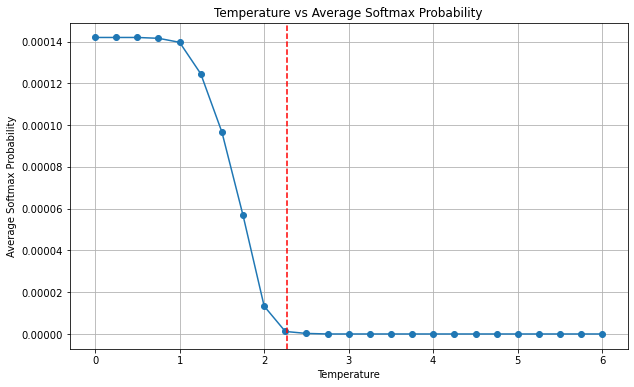

In [79]:
import matplotlib.pyplot as plt

# let's assume temp_list is your list of temperatures and softmax_prob_list is your list of softmax probabilities
Tc = 2 / np.log(1 + np.sqrt(2))  # critical temperature

plt.figure(figsize=(10,6))
plt.plot(temperatures, avg_softmax_probs, 'o-')
plt.axvline(x=Tc, color='r', linestyle='--')  # add vertical line at Tc
plt.xlabel('Temperature')
plt.ylabel('Average Softmax Probability')
plt.title('Temperature vs Average Softmax Probability')
plt.grid(True)
plt.show()




In [ ]:
# need to do the same for infinity ^^

## Run forward and backward passes to produce RBM flow

#### first use inital temp of $T=\infty$

In [95]:
num_visible = 100
infinity_initial = np.random.choice([0, 1], num_visible)
print(infinity_initial)

[1 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1
 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1
 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0]


#### next use inital temp of $T=0$

In [96]:
zero_initial = np.random.choice([0, 0], num_visible)
print(zero_initial)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [119]:
# set the number of iterations i.e number of
# forward and backward passes


num_steps = 5 #THIS IS WRONG

In [130]:
# generate the sequences starting from inifnite temp
# for 5 iterations, take the 5th configuration from the sequences generated
# do this 25,000 times so we have 25,000 x 100 shape data... the same as in the '25 temp config'
# points to chart?... then calculte the probs of each
# temp being seen using the other neural network as a thermometer

infinity_box = []
for i in range(0,25000):
    infinity_sequence = rbm.generate_sequence(infinity_initial, num_steps)
    infinity_box.append(infinity_sequence[4])

In [131]:
np.shape(infinity_box)

(25000, 100)

In [98]:
# generate the sequences starting from zero temp
zero_sequence = rbm.generate_sequence(zero_initial, num_steps)

print(zero_sequence)

[[1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
  0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0.
  0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
  1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 1. 1.]
 [1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
  0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.
  0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
  1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
  1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
  1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
  0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.

In [138]:
def to_spin(binary_array):
    return 2*binary_array - 1

In [ ]:
sequence = to_spin(sequence)

In [ ]:
# Now, here the previous researchers used another NN to analyse the temperatures

In [132]:
# calculate free energies and softmax probs
free_energies_infinity = trained_rbm.free_energy(infinity_box)
softmax_probs_infinity = softmax(-free_energies_infinity)

In [133]:
print(softmax_probs_infinity)

[5.80232132e-08 3.54586368e-11 1.26266812e-09 ... 3.95062904e-10
 9.34444532e-10 1.03000687e-03]


In [136]:
# Reshape the softmax probabilities to match the original data structure
softmax_probs_infinity = softmax_probs_infinity.reshape((25, 1000))
softmax_probs_infinity

array([[5.80232132e-08, 3.54586368e-11, 1.26266812e-09, ...,
        8.30960719e-09, 2.53223184e-12, 1.30149115e-06],
       [2.09000245e-06, 4.10523039e-08, 9.46426860e-09, ...,
        9.53076141e-08, 9.14830525e-08, 2.51687174e-07],
       [8.59012253e-08, 6.70580571e-07, 4.26053800e-11, ...,
        3.84335626e-08, 1.22723677e-10, 1.75834908e-09],
       ...,
       [3.58925952e-07, 3.70587354e-09, 7.56454718e-10, ...,
        1.51589782e-10, 3.49934339e-10, 3.13377144e-12],
       [5.30291325e-12, 8.65136064e-06, 1.74331795e-10, ...,
        4.96896836e-05, 1.01008438e-08, 1.03964419e-10],
       [8.83601876e-11, 6.91135453e-11, 2.12069281e-07, ...,
        3.95062904e-10, 9.34444532e-10, 1.03000687e-03]])

In [137]:
# Calculate average softmax probabilities for each temperature
avg_softmax_probs_infinity = softmax_probs_infinity.mean(axis=1)
avg_softmax_probs_infinity

array([2.38025839e-05, 3.94423491e-05, 3.10066959e-05, 1.68434458e-05,
       2.65070595e-05, 2.94605936e-05, 3.65722003e-05, 9.82346940e-06,
       2.02822885e-04, 5.20648739e-05, 1.63995636e-05, 7.49588415e-05,
       1.87792131e-05, 2.68036234e-05, 6.18004452e-05, 2.00168181e-05,
       3.02341493e-05, 4.19489613e-05, 3.21657615e-05, 1.37592212e-05,
       2.66379360e-05, 1.43663716e-05, 8.85041188e-05, 1.74708889e-05,
       4.78079297e-05])

# NOW BUILD ANOTHER NEURAL NETWORK AS A THERMOMETER AND FIND THE PROBABILITY OF THE TEMPS 1-6 FROM THIS !!!!!!! easyyyyyyyy THEN DONE FOR 5 ITERATIONS. THE OUTPUT OF THE FEED FORWARD NEURAL NETWORK (NN THERMOMETER) IS A SOFTMAX PROBABILITY. THAT IS WHAT IS UP THE SIDE OF THE SCALE!

## note: this looks like $T_0=0$ flows in previous results

In [56]:
num_visible = 100
num_hidden = 100
initial_state = np.random.choice([0, 1], num_visible)  # T = infinity (because completely random spins)
rbm = RBM(num_visible=num_visible, num_hidden=num_hidden)
# Generate sequence
num_steps = 5
sequence = rbm.generate_sequence(initial_state, num_steps)

In [57]:
def calculate_magnetisation(configuration):
    return np.mean(configuration)

In [58]:
def theoretical_magnetisation(T):
    if T < 2 / np.log(1 + np.sqrt(2)):
        return (1 - np.sinh(2 / T) ** (-4)) ** (1 / 8)
    else:
        return 0

In [59]:
# Initialize a list to store the effective temperatures for each configuration
effective_temperatures = []

# For each configuration in the sequence
for config in sequence:
    # Calculate the magnetisation of the configuration
    config_magnetisation = calculate_magnetisation(config)

    # Calculate the theoretical magnetisation for each temperature
    theoretical_magnetisations = np.array([theoretical_magnetisation(T) for T in temperatures])

    # Find the temperature that gives the closest match to the configuration's magnetisation
    effective_temperature = temperatures[np.argmin(np.abs(theoretical_magnetisations - config_magnetisation))]

    # Append to the list of effective temperatures
    effective_temperatures.append(effective_temperature)

/var/folders/w5/2_pjjnd9621bd9yfl2mp6fd80000gn/T/ipykernel_32820/3175088664.py:3: RuntimeWarning: overflow encountered in sinh
  return (1 - np.sinh(2 / T) ** (-4)) ** (1 / 8)


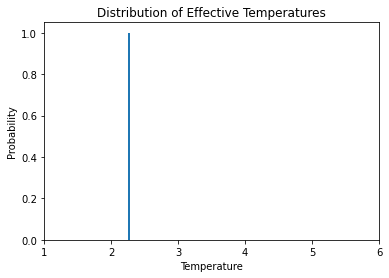

In [60]:

# Convert the list of effective temperatures into a numpy array
effective_temperatures = np.array(effective_temperatures)

# Plot the histogram of effective temperatures
plt.hist(effective_temperatures, bins=30, weights=np.ones(len(effective_temperatures)) / len(effective_temperatures))
plt.xlabel('Temperature')
plt.ylabel('Probability')
plt.title('Distribution of Effective Temperatures')
plt.xlim([1, 6])  # Set the range of the x-axis to be between 1 and 6
plt.show()

# RBM Flow function

In [63]:
# Generate sequence
def RBM_Flow(num_visible, num_hidden, initial_state, num_steps, repeat):
    
    
    sequence = rbm.generate_sequence(initial_state, num_steps)
    temperatures = [0.000001, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 
                3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0]
    
    def calculate_magnetisation(configuration):
        return np.mean(configuration)
    
    def theoretical_magnetisation(T):
        if T < 2 / np.log(1 + np.sqrt(2)):
            return (1 - np.sinh(2 / T) ** (-4)) ** (1 / 8)
        else:
            return 0
        
    average_effective_temperature = []
    for n in range(0,len(repeat)):
    # Initialize a list to store the effective temperatures for each configuration
        effective_temperatures = []

    # For each configuration in the sequence
        for config in sequence:
        # Calculate the magnetisation of the configuration
            config_magnetisation = calculate_magnetisation(config)

        # Calculate the theoretical magnetisation for each temperature
            theoretical_magnetisations = np.array([theoretical_magnetisation(T) for T in temperatures])

        # Find the temperature that gives the closest match to the configuration's magnetisation
            effective_temperature = temperatures[np.argmin(np.abs(theoretical_magnetisations - config_magnetisation))]

        # Append to the list of effective temperatures
            effective_temperatures.append(effective_temperature)
            
            